#### Cycling through data science: model <img src="../images/bicycle32.png" style="float:right">

Preamble: Gather features which might help predict the number of bike users in any given day in Washington, DC, and evaluate the significance of those features and the robustness of the predictions. This is essentially a `regression problem`. Regression problems are inference problems in that we infer, or predict, parameters of a population from a sample. They are also specifically `supervised learning` problems that entail building a model to make predictions about a continuous target variable.

##### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, impute, model_selection, preprocessing, compose, pipeline, metrics, linear_model, neighbors
import catboost

import joblib
from loguru import logger
import warnings

##### Set parameters

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

##### Define functions

In [3]:
def plot_correlation_features_to_target(data, target):
    '''Plot heatmap of how features correlate to the target variable.'''
    df_corr = data.corr()[[target]].sort_values(by=target, ascending=False)
    plt.title(label=f'Correlation of features to {target}')
    sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap='coolwarm', xticklabels=False)

In [4]:
def fit_preprocessing_pipeline(X, numerical_features=None, nominal_features=None, ordinal_features=None, path='../data'):
    '''Return a dataframe and pipe object after fitting and transforming it to a preprocessing pipeline. In addition, save only the fitted pipeline.'''    
    # Convert nominal features to category datatype
    X[nominal_features] = X[nominal_features].astype('category')
    # Build preprocessing for numerical features
    numerical_transformer = pipeline.Pipeline(steps=[
        ('impute', impute.KNNImputer()),
        ('scale', preprocessing.StandardScaler())
    ])
    # Build preprocessing for nominal features
    nominal_transformer = pipeline.Pipeline(steps=[
        ('impute', impute.SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ])
    # Build preprocessing for ordinal features
    ordinal_transformer = pipeline.Pipeline(steps=[
        ('impute', impute.SimpleImputer(strategy='mean')),
        ('onehot', preprocessing.OrdinalEncoder())
    ])
    # Build ColumnTransformer 
    preprocessor = compose.ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('nominal', nominal_transformer, nominal_features),
        ('ordinal', ordinal_transformer, ordinal_features),
    ])
    # Build and fit pipeline
    pipe = pipeline.Pipeline(steps=[
        ('preprocess', preprocessor)
    ])
    pipe = pipe.fit(X)
    # Pickle the fitted pipeline into preprocessing.joblib file
    joblib.dump(pipe, open(f"{path}/preprocessing.joblib",'wb'))
    X = pipe.transform(X)
    return X, pipe

In [5]:
def fit_model(X, y, model_type=linear_model.LinearRegression(), parameters={}, path='../data'):
    '''Return the optimal model object fitted using a preprocessing pipeline and cross-validated gridsearch.'''
    # Pipeline for instantiating model
    pm = pipeline.Pipeline([
        ('model', model_type)
    ])
    # Build and fit gridsearch model
    parameters = parameters
    grid = model_selection.GridSearchCV(estimator=pm, param_grid=parameters, n_jobs=-1)
    model = grid.fit(X, y)
    # Display best attributes
    logger.info(f"For model: {model_type}")
    logger.info(f"The best parameters are: {model.best_params_}")
    logger.info(f"The best score is: {model.best_score_:.4f}")
    # Pickle the trained model into model.joblib file
    joblib.dump(model, open(f"{path}/model.joblib",'wb'))
    return model

In [6]:
def evaluate_model(model, pipe, X_train, X_test, y_train, y_test):
    '''Return predictions for training and testing data using trained model and fitted preprocessing pipeline.'''
    # Preprocess test data using preprocessing pipeline object
    X_test = pipe.transform(X_test)
    # Predict training and testing values
    y_train_pred = model.predict(X=X_train)
    y_test_pred = model.predict(X=X_test)
    # Display number of total observations and scores for training and testing data
    logger.info(f'Number of total observations in dataset: {len(y_train_pred) + len(y_test_pred):,}')
    logger.info(f'Training data score (r2): {metrics.r2_score(y_true=y_train, y_pred=y_train_pred):.4f}')
    logger.info(f'Testing data score (r2): {metrics.r2_score(y_true=y_test, y_pred=y_test_pred):.4f}')
    logger.info(f'Bias-variance trade-off (test score / train score): {metrics.r2_score(y_true=y_test, y_pred=y_test_pred) / metrics.r2_score(y_true=y_train, y_pred=y_train_pred):.4f}')
    # Display error curve
    sns.distplot(a=y_test_pred-y_test, label=None)
    plt.ylabel('')    
    plt.xlabel('')
    return y_train_pred, y_test_pred

#### 1. Define data science problem

Business problem: predict the number of bike users in any given day in Washington, DC.  
Data science problem: given a set of weather and time variables, predict the number of bike users in a given day.  

#### 2. Gather and process data

In [7]:
# Load daily bike count dataset
path = '../data'
data = pd.read_csv(f'{path}/day.csv')

In [8]:
# Rename and select columns
cols_dict = {
    'cnt': 'count',
    'season': 'season',
    'yr': 'year',
    'mnth': 'month',
    'holiday': 'is_holiday',
    'weekday': 'weekday',
    'workingday': 'is_workingday',
    'weathersit': 'weather',
    'temp': 'temp',
    'atemp': 'temp_feel',
    'hum': 'humdity',
    'windspeed': 'windspeed',
}
data = data.rename(columns=cols_dict).loc[:, cols_dict.values()]

##### Data table
- `count`: count of total rental bikes including both casual and registered 
- `season`: season (1:spring, 2:summer, 3:fall, 4:winter)
- `year`: year (0: 2011, 1:2012)
- `month`: month ( 1 to 12)
- `is_holiday`: whether day is holiday or not
- `weekday`: day of the week
- `is_workingday`: if day is neither weekend nor holiday is 1, otherwise is 0
- `weather`: 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: normalized daily temperature in Celsius
- `temp_feel`: normalized daily feeling temperature in Celsius
- `humidity`: normalized humidity. The values are divided to 100 (max)
- `windspeed`: normalized wind speed. The values are divided to 67 (max)

In [9]:
# View header
data.head()

,count,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed
0,985,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,801,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1349,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1562,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1600,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [10]:
# Assign to df and define target column
df = data
target = 'count'

#### 3. Explore and transform data

In [11]:
df.head()

,count,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed
0,985,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,801,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1349,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1562,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1600,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   count          731 non-null    int64  
 1   season         731 non-null    int64  
 2   year           731 non-null    int64  
 3   month          731 non-null    int64  
 4   is_holiday     731 non-null    int64  
 5   weekday        731 non-null    int64  
 6   is_workingday  731 non-null    int64  
 7   weather        731 non-null    int64  
 8   temp           731 non-null    float64
 9   temp_feel      731 non-null    float64
 10  humdity        731 non-null    float64
 11  windspeed      731 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


In [13]:
df.describe()

,count,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,4504.348837,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486
std,1937.211452,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498
min,22.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392
25%,3152.000000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950
50%,4548.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975
75%,5956.000000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214
max,8714.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463


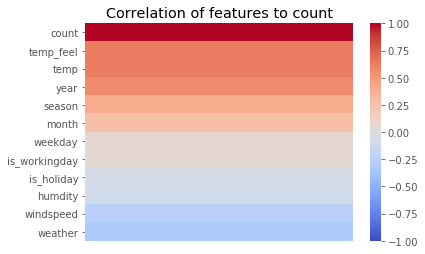

In [14]:
# Plot heatmap of how features correlate to the target variable
plot_correlation_features_to_target(data=df, target=target)

##### Transform features

Transformation of features such as one-hot encoding and scaling is built into the `fit_preprocessing_pipeline` function and processed in the `Model and evaluate` section of this notebook.

#### 4. Model and evaluate

In [15]:
# Define type of features
numerical_features = [
    'temp', 
    'temp_feel', 
    'humdity', 
    'windspeed', 
]
nominal_features = [
    'season', 
    'month', 
    'is_holiday', 
    'weekday', 
    'is_workingday',
    'weather'
]
ordinal_features = [
]

In [16]:
# Define features and target
X = pd.concat([df[numerical_features], df[nominal_features], df[ordinal_features]], axis=1)
y = df[target]

In [17]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)

In [18]:
# Preprocess features through preprocessing pipeline
X_train, prepipe = fit_preprocessing_pipeline(X=X_train, numerical_features=numerical_features, nominal_features=nominal_features, ordinal_features=ordinal_features, path=path)

##### Linear regression with regularization

2020-04-18 18:16:42.641 | INFO     | __main__:fit_model:12 - For model: ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
2020-04-18 18:16:42.642 | INFO     | __main__:fit_model:13 - The best parameters are: {'model__l1_ratio': 1.0, 'model__n_alphas': 130}
2020-04-18 18:16:42.643 | INFO     | __main__:fit_model:14 - The best score is: 0.5274
2020-04-18 18:16:42.664 | INFO     | __main__:evaluate_model:9 - Number of total observations in dataset: 731
2020-04-18 18:16:42.669 | INFO     | __main__:evaluate_model:10 - Training data score (r2): 0.5825
2020-04-18 18:16:42.675 | INFO     | __main__:evaluate_model:11 - Testing data score (r2): 0.5511
2020-04-18 18:16:42.680 | INFO     | __main__:evaluate_model:12 - Bias-variance trade-off (test score / train s

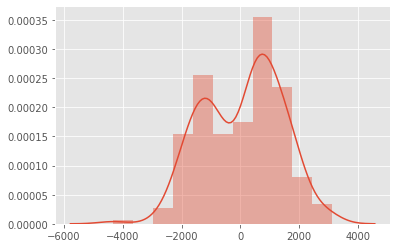

In [19]:
# Set preprocessing and modeling parameters, fit model, and evaluate training and testing scores using trained model
parameters = {
    'model__l1_ratio': [0.9, 1.0],
    'model__n_alphas': [130, 140]
}
model_type = linear_model.ElasticNetCV()
model = fit_model(X=X_train, y=y_train, model_type=model_type, parameters=parameters, path=path)
y_train_pred, y_test_pred = evaluate_model(model=model, pipe=prepipe, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

##### Catboost

2020-04-18 18:16:56.601 | INFO     | __main__:fit_model:12 - For model: <catboost.core.CatBoostRegressor object at 0x000001A4AF0DC208>
2020-04-18 18:16:56.603 | INFO     | __main__:fit_model:13 - The best parameters are: {}
2020-04-18 18:16:56.604 | INFO     | __main__:fit_model:14 - The best score is: 0.5649
2020-04-18 18:16:56.646 | INFO     | __main__:evaluate_model:9 - Number of total observations in dataset: 731
2020-04-18 18:16:56.650 | INFO     | __main__:evaluate_model:10 - Training data score (r2): 0.9427
2020-04-18 18:16:56.653 | INFO     | __main__:evaluate_model:11 - Testing data score (r2): 0.6257
2020-04-18 18:16:56.659 | INFO     | __main__:evaluate_model:12 - Bias-variance trade-off (test score / train score): 0.6638


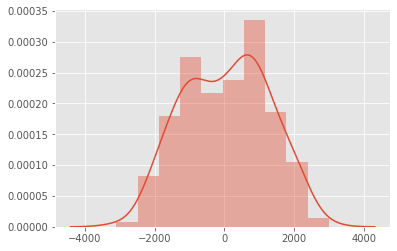

In [20]:
# Set preprocessing and modeling parameters, fit model, and evaluate training and testing scores using trained model
parameters = {
}
model_type = catboost.CatBoostRegressor(silent=True)
model = fit_model(X=X_train, y=y_train, model_type=model_type, parameters=parameters, path=path)
y_train_pred, y_test_pred = evaluate_model(model=model, pipe=prepipe, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

#### 5. Interact with trained model

User enters these features

In [21]:
input_user = {
    'temp': [0.344167, 0.644162], 
    'temp_feel': [0.363625, 0.363625], 
    'humdity': [0.805833, 0.805833], 
    'windspeed': [0.160446, 0.160446], 
    'season': [1, 1], 
    'month': [1, 1], 
    'is_holiday': [0, 0], 
    'weekday': ['sunday', 'monday'], 
    'is_workingday': [0, 1],
    'weather': [2, 3]
}
df_user = pd.DataFrame(data=input_user)

Load the fitted preprocessing and model objects

In [22]:
# Load the preprocessing pipeline and trained model objects
prepipe = joblib.load(open(f'{path}/preprocessing.joblib', 'rb'))
model = joblib.load(open(f'{path}/model.joblib','rb'))

Make prediction using trained model

In [23]:
# Transform features using fitted preprocessing pipeline and make prediction using trained model
df_user['count_predictions'] = model.predict(X=prepipe.transform(X=df_user))
df_user

,temp,temp_feel,humdity,windspeed,season,month,is_holiday,weekday,is_workingday,weather,count_predictions
0,0.344167,0.363625,0.805833,0.160446,1,1,0,sunday,0,2,1895.410364
1,0.644162,0.363625,0.805833,0.160446,1,1,0,monday,1,3,3662.406109


#### 6. Answer data science problem

Given a set of weather and time variables, we can predict the number of bike users in any given day in Washington, DC.